# Quadratic Regression

-NOTE: 
- PubChemQC DFT calculations were run on GAUSSIAN with wb97X-D
- Hexamer DFT calculations were run on ORCA with wb97X (no dispersion)

### Imports

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

### Data Processing

Load & Proccess PubChemQC Data

In [2]:
pcqc = pd.read_csv('../data/PolarizabilityComparison.csv')
# drop all rows that are NOT from PubChemQC
pcqc = pcqc[pcqc.Folder == 'pubchemqc']
pcqc = pcqc.reset_index(drop=True)
pcqc = pcqc[['Molecule', 'alpha_GFN2', 'alpha_wb97']]
#rename columns
pcqc = pcqc.rename(columns={'Molecule':'name', 'alpha_GFN2':'gfn2_alpha(A^3)', 'alpha_wb97':'dft_alpha(A^3)'})

pcqc.tail()

,name,gfn2_alpha(A^3),dft_alpha(A^3)
8410,524145,20.912364,20.911826
8411,64293607,25.082908,25.083226
8412,21300214,18.176059,18.176337
8413,20782728,15.164950,15.165223
8414,14546131,20.724897,20.725114


Load & Process Wide Range Set Data

In [3]:
wr = pd.read_csv('../data/polar_benchmark_master.csv')
wr = wr[['ID', 'GFN2', 'wB97X/cc-pVTZ']]
#rename columns
wr = wr.rename(columns={'ID':'name', 'GFN2':'gfn2_alpha(A^3)', 'wB97X/cc-pVTZ':'dft_alpha(A^3)'})

wr.tail()

,name,gfn2_alpha(A^3),dft_alpha(A^3)
68,1175_67_010101,246.577641,420.328366
69,410_658_001000,256.029135,392.290343
70,867_397_111011,259.184933,432.635864
71,379_282_000100,260.776229,464.997122
72,379_525_001000,276.044063,415.776671


Combine PubChemQC & Wide Range DFs

In [4]:
# NOTE: dft_alpha column uses slightly different methods for pcqc & hexamers; see note at top
master = pd.concat([pcqc, wr], ignore_index=True)
master

,name,gfn2_alpha(A^3),dft_alpha(A^3)
0,6993689,23.286897,182.856970
1,58301030,21.095607,143.897728
2,22889495,23.375069,125.229418
3,58364267,15.331243,96.314135
4,25200997,11.216928,67.985664
...,...,...,...
8483,1175_67_010101,246.577641,420.328366
8484,410_658_001000,256.029135,392.290343
8485,867_397_111011,259.184933,432.635864
8486,379_282_000100,260.776229,464.997122


### Method Definition

In [5]:
'''
    Calculates root mean square error

    Parameters
    ---------
    predictions: ndarray of floats
        expected values [based on best fit line]
    observations: ndarray of floats
        observed values
    
    Returns
    -------
    rmse: float
        root mean square error
'''
def calc_rmse(predictions, observations):
    rmse = np.sqrt(((predictions - observations) ** 2).mean())
    return rmse

In [6]:
'''
    Performs linear regression on data set and calculates associated values

    Parameters
    ---------
    x: ndarray of floats
        x values
    y: ndarray of floats
        y values
    intercept: boolean
        if true, calculates y intercept, if false sets y intercept to 0 (forces fit)
    
    Returns
    -------
    lin_regress_var: list of floats
        slope, y-intercept, r^2, root mean square error
'''

def perform_lin_regress(x, y, intercept=True):  
     
    # 2D X array necessary for sklearn
    xi = x.reshape((-1,1))

    model = LinearRegression(fit_intercept = intercept)
    model.fit(xi,y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(xi,y)
    
    # calculate RMSE
    y_pred = y
    y_true = []
    for val in x: 
        y_tr = slope*val + intercept
        y_true.append(y_tr)
    y_true = np.array(y_true)

    rmse = calc_rmse(y_pred, y_true)
    
    lin_regress_var = [slope, intercept, r_squared, rmse]
    
    return lin_regress_var

In [7]:
'''
    Performs linear regression on data set and calculates associated values

    Parameters
    ---------
    x: ndarray of floats
        x values
    y: ndarray of floats
        y values
    intercept: boolean
        if true, calculates y intercept, if false sets y intercept to 0 (forces fit)
    
    Returns
    -------
    lin_regress_var: list of floats
        slope, y-intercept, r^2, root mean square error
'''
# HELPFUL: https://stackoverflow.com/questions/33876900/how-to-extract-equation-from-a-polynomial-fit/33876965
def perform_quad_regress(x, y, intercept=True):  
     
    # 2D X array necessary for sklearn
    xi = x.reshape((-1,1))
    
    # use transformer to put input data matrix into new matrix of 2nd degree
    # include_bias acts as an intercept term
    poly = PolynomialFeatures(degree=2, include_bias=intercept)
    x_trans = poly.fit_transform(xi)
    
    # PolynomialFeatures already takes care of intercept
    model = LinearRegression(fit_intercept=False)
    model.fit(x_trans,y)
    
    coeffs = model.coef_
    intercept = model.intercept_

    quad_regress_var = [coeffs, intercept]
    
    return quad_regress_var

In [8]:
# matplotlib global formatting

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.rcParams['figure.dpi'] = 300

### Calculate MAE Comparison For Linear and Quadratic Fit

In [9]:
x = master['gfn2_alpha(A^3)'].values
y = master['dft_alpha(A^3)'].values

# perform linear regression
slope, intercept, r_squared, rmserror = perform_lin_regress(x, y, False)

# perform quadratic regression
q_coeffs, q_intercept = perform_quad_regress(x, y, False)

master_copy = master.copy()
master_copy['linear'] = master_copy['gfn2_alpha(A^3)']*slope
master_copy['quadratic'] = master_copy['gfn2_alpha(A^3)']*q_coeffs[0] + (master_copy['gfn2_alpha(A^3)']**2)*q_coeffs[1]
master_copy.tail()

,name,gfn2_alpha(A^3),dft_alpha(A^3),linear,quadratic
8483,1175_67_010101,246.577641,420.328366,332.469119,525.744573
8484,410_658_001000,256.029135,392.290343,345.212894,557.344022
8485,867_397_111011,259.184933,432.635864,349.467965,568.083101
8486,379_282_000100,260.776229,464.997122,351.613564,573.533967
8487,379_525_001000,276.044063,415.776671,372.199709,627.050434


In [10]:
# MAE wb97X(D) vs linear-fit GFN2
mae_linear=mean_absolute_error(master_copy['dft_alpha(A^3)'], master_copy['linear'])

In [11]:
# MAE wb97X(D) vs quadratic-fit GFN2
mae_quadratic=mean_absolute_error(master_copy['dft_alpha(A^3)'], master_copy['quadratic'])

### Plot

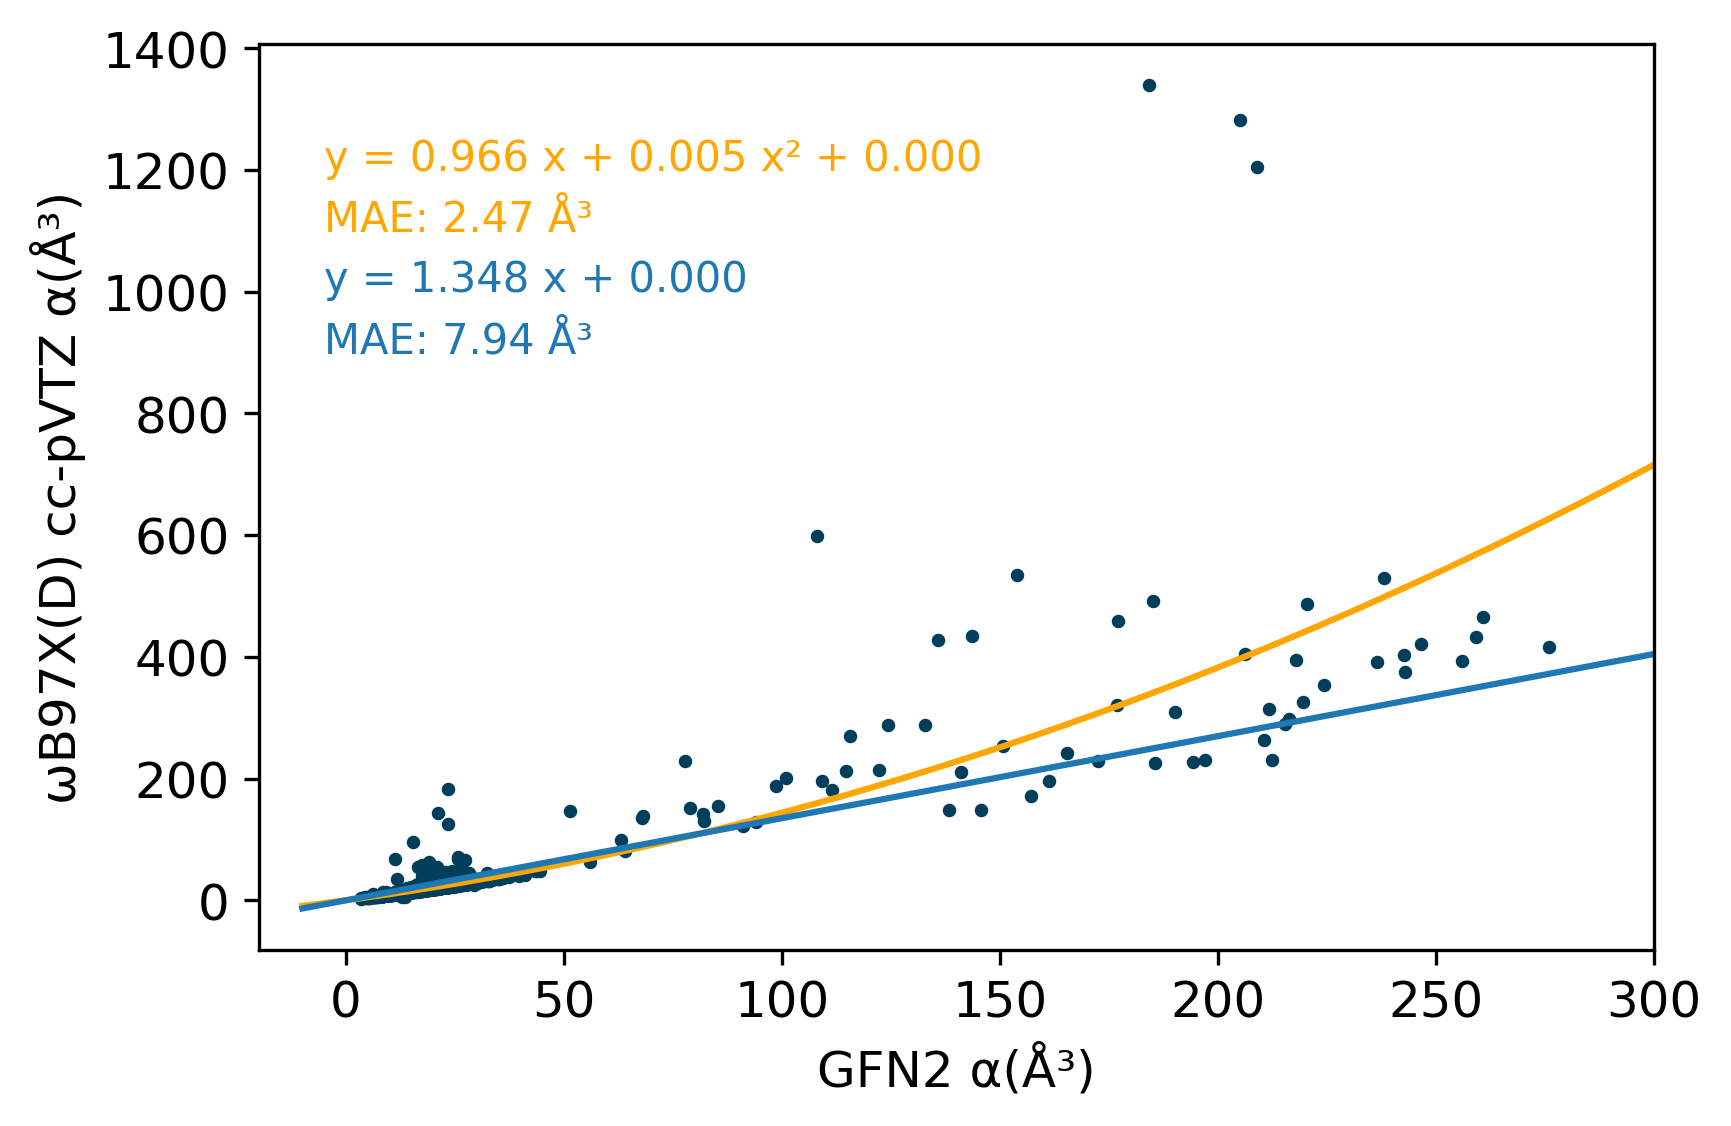

In [12]:
x = master['gfn2_alpha(A^3)'].values
y = master['dft_alpha(A^3)'].values

# label axes
plt.xlabel('GFN2 α(Å³)')
plt.ylabel('ωB97X(D) cc-pVTZ α(Å³)')

# set axes limits
plt.xlim(-20, 300)

# perform linear regression
slope, intercept, r_squared, rmserror = perform_lin_regress(x, y, False)

# perform quadratic regression
q_coeffs, q_intercept = perform_quad_regress(x, y, False)

# plot points & regression lines
plt.scatter(x, y, s=5, c='#003f5c')
# reassign x to grid of points (otherwise quadratic line will be warped)
x = np.linspace(-10, 300, 1000)
plt.plot(x, q_coeffs[0]*x+q_coeffs[1]*x**2+q_intercept, c='#ffa600')
plt.plot(x, slope*x+intercept, c='#1f77b4')

# print regression line equations
plt.text(-5, 1200, 'y = %.3f x + %.3f x² + %.3f' % (q_coeffs[0], q_coeffs[1],  q_intercept), color='#ffa600')
plt.text(-5, 1100, 'MAE: %.2f Å³' % mae_quadratic, color='#ffa600')
plt.text(-5, 1000, 'y = %.3f x + %.3f' % (slope, intercept), color='#1f77b4')
plt.text(-5, 900, 'MAE: %.2f Å³' % mae_linear, color='#1f77b4')


# plt.savefig('quadratic_regression.png', transparent=False, bbox_inches='tight')

plt.show()